In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import pickle
import random
import os

# === Paths ===
GT_PATH = '/content/drive/MyDrive/Colab Notebooks/New_Project-UCF/UCF-Crime/GT_anomaly.pkl'
EXCLUSION_PATH = '/content/drive/MyDrive/Colab Notebooks/New_Project-UCF/UCF-Crime/exclusion.pkl'
SAVE_DIR = '/content/drive/MyDrive/Colab Notebooks/New_Project-UCF/UCF-Crime/splits/'  # where train.txt, val.txt, test.txt will be saved
os.makedirs(SAVE_DIR, exist_ok=True)

# === Load ground truth and exclusions ===
with open(GT_PATH, 'rb') as f:
    gt_dict = pickle.load(f)

with open(EXCLUSION_PATH, 'rb') as f:
    exclusion_list = pickle.load(f)

extra_excluded_videos = [f"Normal_Videos_{i}_x264" for i in range(951, 1000)]
excluded_videos = set(exclusion_list + extra_excluded_videos)

# === Filter valid videos into Normal and Abnormal ===
normal_videos = []
abnormal_videos = []

for video_name, meta in gt_dict.items():
    if video_name in excluded_videos:
        continue
    if int(meta["class"]) == 8:
        normal_videos.append(video_name)
    else:
        abnormal_videos.append(video_name)

# === Shuffle both categories ===
random.seed(42)
random.shuffle(normal_videos)
random.shuffle(abnormal_videos)

# === Determine max balanced size ===
max_per_class = min(len(normal_videos), len(abnormal_videos))

# === Determine per split size ===
num_train = int(0.7 * max_per_class)
num_val = int(0.15 * max_per_class)
num_test = max_per_class - num_train - num_val

# === Slice for each split ===
train_normals = normal_videos[:num_train]
train_abnormals = abnormal_videos[:num_train]

val_normals = normal_videos[num_train:num_train + num_val]
val_abnormals = abnormal_videos[num_train:num_train + num_val]

test_normals = normal_videos[num_train + num_val:num_train + num_val + num_test]
test_abnormals = abnormal_videos[num_train + num_val:num_train + num_val + num_test]

# === Helper function to save splits ===
def save_split(normals, abnormals, name):
    combined = normals + abnormals
    random.shuffle(combined)

    with open(os.path.join(SAVE_DIR, f'{name}.txt'), 'w') as f:
        for video in combined:
            f.write(video + '\n')

    print(f"✅ {name.capitalize()} split saved → Total: {len(combined)}")
    print(f"   → Normal: {len(normals)}, Abnormal: {len(abnormals)}")

# === Save splits ===
save_split(train_normals, train_abnormals, 'train_1')
save_split(val_normals, val_abnormals, 'val_1')
save_split(test_normals, test_abnormals, 'test_1')

print(f"\n🎯 Done! Balanced (1:1) splits saved to: {SAVE_DIR}")


✅ Train_1 split saved → Total: 1298
   → Normal: 649, Abnormal: 649
✅ Val_1 split saved → Total: 278
   → Normal: 139, Abnormal: 139
✅ Test_1 split saved → Total: 280
   → Normal: 140, Abnormal: 140

🎯 Done! Balanced (1:1) splits saved to: /content/drive/MyDrive/Colab Notebooks/New_Project-UCF/UCF-Crime/splits/


In [ ]:
import torch
from torch.utils.data import Dataset
import os
import numpy as np
import re

# === Utility: Normalize names ===
def normalize_video_name(name):
    return re.sub(r'(Normal_Videos)(\d+)', r'\1_\2', name)

# === Utility: Denormalize names ===
def denormalize_video_name(name):
    return name.replace("Normal_Videos_", "Normal_Videos")


class UCFDataset(Dataset):
    def __init__(self,
                 split_file,
                 gt_dict,
                 frames_dict,
                 features_dir,
                 feature_type='rgb',
                 transform=None):
        """
        Args:
            split_file (str): Path to the split file (train/test)
            gt_dict (dict): Ground truth annotations
            frames_dict (dict): Frame count for each video
            features_dir (dict): {'rgb': path, 'flow': path}
            feature_type (str): 'rgb', 'flow', or 'both'
            transform (callable, optional): Optional transform on features
        """
        with open(split_file, 'r') as f:
            self.video_list = [line.strip() for line in f.readlines()]

        self.gt_dict = gt_dict
        self.frames_dict = frames_dict
        self.features_dir = features_dir
        self.feature_type = feature_type
        self.transform = transform

    def __len__(self):
        return len(self.video_list)

    def safe_feature_load(self, base_path, video_name):
        """Try loading features with both normalized and denormalized names"""
        norm_name = normalize_video_name(video_name)
        denorm_name = denormalize_video_name(norm_name)

        paths_to_try = [
            os.path.join(base_path, f"{norm_name}.mp4.npy"),
            os.path.join(base_path, f"{denorm_name}.mp4.npy")
        ]

        for path in paths_to_try:
            if os.path.exists(path):
                return np.load(path)

        raise FileNotFoundError(f"❌ Feature file not found for: {video_name} in {base_path}")

    def safe_get_frames(self, video_name):
        """Try retrieving frame count using both key formats"""
        norm_name = normalize_video_name(video_name)
        denorm_name = denormalize_video_name(norm_name)

        if norm_name in self.frames_dict:
            return self.frames_dict[norm_name]
        elif denorm_name in self.frames_dict:
            return self.frames_dict[denorm_name]
        else:
            raise KeyError(f"❌ Frame count not found for: {video_name}")

    def __getitem__(self, idx):
        raw_video_name = self.video_list[idx]
        video_name = normalize_video_name(raw_video_name)

        # === Load features ===
        if self.feature_type == 'rgb':
            feature = self.safe_feature_load(self.features_dir['rgb'], video_name)
        elif self.feature_type == 'flow':
            feature = self.safe_feature_load(self.features_dir['flow'], video_name)
        elif self.feature_type == 'both':
            rgb_feat = self.safe_feature_load(self.features_dir['rgb'], video_name)
            flow_feat = self.safe_feature_load(self.features_dir['flow'], video_name)
            feature = np.concatenate((rgb_feat, flow_feat), axis=-1)
        else:
            raise ValueError("Invalid feature_type. Choose from 'rgb', 'flow', or 'both'.")

        # === Get video-level label ===
        try:
            video_info = self.gt_dict[video_name]
        except KeyError:
            raise KeyError(f"❌ GT entry missing for: {video_name}")

        video_class = int(video_info['class'])  # 8 = normal, others = abnormal
        label = 0.0 if video_class == 8 else 1.0  # 0 = Normal, 1 = Abnormal

        if self.transform:
            feature = self.transform(feature)

        feature = torch.tensor(feature, dtype=torch.float32)
        label = torch.tensor(label, dtype=torch.float32)

        return feature, label, raw_video_name




🎞️  Video: Normal_Videos_538_x264
🧼 Feature tensor shape: torch.Size([1, 32, 1024])
📊 Video-level Label: Normal
📌 Total frames: 1013
✅ Normal video (no anomalies)


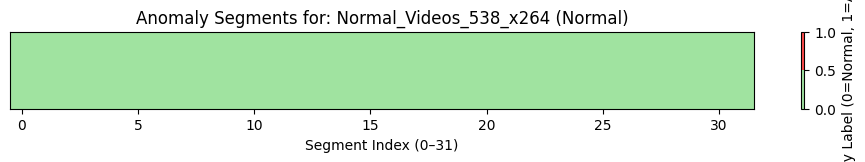

In [ ]:
import re
import pickle
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from torch.utils.data import DataLoader

# === Utility: Normalization functions ===
def normalize_video_name(name):
    return re.sub(r'(Normal_Videos)(\d+)', r'\1_\2', name)

def denormalize_video_name(name):
    return name.replace("Normal_Videos_", "Normal_Videos")

# === Load dataset paths ===
split_path = '/content/drive/My Drive/Colab Notebooks/New_Project-UCF/UCF-Crime/splits/train.txt'
features_dir = {
    'rgb': '/content/drive/MyDrive/Colab Notebooks/New_Project-UCF/UCF-Crime/all_rgbs',
    'flow': '/content/drive/MyDrive/Colab Notebooks/New_Project-UCF/UCF-Crime/all_flows'
}

with open('/content/drive/MyDrive/Colab Notebooks/New_Project-UCF/UCF-Crime/GT_anomaly.pkl', 'rb') as f:
    gt_dict = pickle.load(f)

with open('/content/drive/MyDrive/Colab Notebooks/New_Project-UCF/UCF-Crime/frames.pkl', 'rb') as f:
    frames_dict = pickle.load(f)

# === Dataset and DataLoader ===
dataset = UCFDataset(
    split_file=split_path,
    gt_dict=gt_dict,
    frames_dict=frames_dict,
    features_dir=features_dir,
    feature_type='rgb'  # or 'both'
)

loader = DataLoader(dataset, batch_size=1, shuffle=True)

# === Custom binary colormap ===
custom_cmap = ListedColormap(['#a0e3a0', '#ff4d4d'])  # green = normal, red = abnormal

# === Visualize one sample ===
for features, label, video_name in loader:
    video_name = video_name[0]
    print(f"\n🎞️  Video: {video_name}")
    print(f"🧼 Feature tensor shape: {features.shape}")
    print(f"📊 Video-level Label: {'Abnormal' if label.item() == 1.0 else 'Normal'}")

    # Normalize video name to fetch frame count
    norm_name = normalize_video_name(video_name)
    denorm_name = denormalize_video_name(norm_name)
    total_frames = frames_dict.get(norm_name) or frames_dict.get(denorm_name)

    if not total_frames:
        print("❌ Could not find total frame count. Skipping.")
        continue

    print(f"📌 Total frames: {total_frames}")
    segment_size = total_frames / 32

    # Only show anomaly frame mapping if abnormal
    if label.item() == 1.0:
        info = gt_dict.get(norm_name, gt_dict.get(denorm_name, {}))
        anomaly_frames = list(map(int, info.get('gt', [])))
        ranges = list(zip(anomaly_frames[::2], anomaly_frames[1::2]))

        print("🚨 Anomaly frame ranges and their corresponding segments:")
        for a_start, a_end in ranges:
            seg_start = int(a_start / segment_size)
            seg_end = int(a_end / segment_size)
            print(f"   - Frames {a_start}–{a_end} → Segments {seg_start} to {seg_end}")
    else:
        print("✅ Normal video (no anomalies)")

    # === Visualize 32-segment anomaly bar ===
    plt.figure(figsize=(12, 1))
    plt.title(f"Anomaly Segments for: {video_name} ({'Abnormal' if label.item() == 1.0 else 'Normal'})")
    bar = [label.item()] * 32
    plt.imshow([bar], cmap=custom_cmap, aspect='auto', vmin=0, vmax=1)
    plt.xlabel("Segment Index (0–31)")
    plt.yticks([])
    plt.colorbar(label='Anomaly Label (0=Normal, 1=Abnormal)')
    plt.show()

    break  # visualize just one video


In [ ]:
import torch
import torch.optim as optim
import torch.nn as nn
import pickle
import time
import json
import os
from torch.utils.data import DataLoader
from datetime import datetime

# Hyperparameters
BATCH_SIZE = 4
EPOCHS = 20
LEARNING_RATE = 1e-4
FEATURE_TYPE = 'both'  # Choose from: 'rgb', 'flow', or 'both'

# Timestamp for folder naming
timestamp = datetime.now().strftime("%Y%m%d-%H%M%S")
SAVE_DIR = f'/content/drive/MyDrive/Colab Notebooks/New_Project-UCF/models/LSTM-VideoLevel_{FEATURE_TYPE}_{timestamp}'
os.makedirs(SAVE_DIR, exist_ok=True)

# === Load .pkl files ===
with open('/content/drive/MyDrive/Colab Notebooks/New_Project-UCF/UCF-Crime/GT_anomaly.pkl', 'rb') as f:
    gt_dict = pickle.load(f)
with open('/content/drive/MyDrive/Colab Notebooks/New_Project-UCF/UCF-Crime/frames.pkl', 'rb') as f:
    frames_dict = pickle.load(f)

features_dir = {
    'rgb': '/content/drive/MyDrive/Colab Notebooks/New_Project-UCF/UCF-Crime/all_rgbs',
    'flow': '/content/drive/MyDrive/Colab Notebooks/New_Project-UCF/UCF-Crime/all_flows'
}

# Train/Val splits
train_split = '/content/drive/MyDrive/Colab Notebooks/New_Project-UCF/UCF-Crime/splits/train_1.txt'
val_split = '/content/drive/MyDrive/Colab Notebooks/New_Project-UCF/UCF-Crime/splits/val_1.txt'

train_dataset = UCFDataset(train_split, gt_dict, frames_dict, features_dir, feature_type=FEATURE_TYPE)
val_dataset = UCFDataset(val_split, gt_dict, frames_dict, features_dir, feature_type=FEATURE_TYPE)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_dim = 2048 if FEATURE_TYPE == 'both' else 1024

# === Define Model ===
class LSTMAnomalyDetector(nn.Module):
    def __init__(self, input_dim=1024, hidden_dim=512, num_layers=2, output_dim=1):
        super(LSTMAnomalyDetector, self).__init__()
        self.lstm = nn.LSTM(input_size=input_dim,
                            hidden_size=hidden_dim,
                            num_layers=num_layers,
                            batch_first=True,
                            bidirectional=True)
        self.fc = nn.Sequential(
            nn.Linear(hidden_dim * 2, 128),
            nn.ReLU(),
            nn.Linear(128, output_dim),
            nn.Sigmoid()
        )

    def forward(self, x):
        lstm_out, _ = self.lstm(x)              # [B, T, 2*hidden_dim]
        out = self.fc(lstm_out)                 # [B, T, 1]
        out = out.mean(dim=1)                   # [B, 1] — average over time
        return out.squeeze(-1)                  # [B]


# === Initialize training stuff ===
model = LSTMAnomalyDetector(input_dim=input_dim).to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=2, factor=0.5, verbose=True)

# Early stopping
patience = 5
best_val_loss = float('inf')
epochs_without_improvement = 0

# Store epoch losses
train_losses = []
val_losses = []

# === Train Function ===
def train(model, loader, optimizer, criterion):
    model.train()
    total_loss = 0
    for features, labels, _ in loader:
        features, labels = features.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(features)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

# === Validate Function ===
def validate(model, loader, criterion):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for features, labels, _ in loader:
            features, labels = features.to(device), labels.to(device)
            outputs = model(features)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
    return total_loss / len(loader)

# === Training Loop ===
for epoch in range(EPOCHS):
    start_time = time.time()

    train_loss = train(model, train_loader, optimizer, criterion)
    val_loss = validate(model, val_loader, criterion)

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    print(f"Epoch {epoch+1}/{EPOCHS} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_without_improvement = 0
        best_model_path = os.path.join(SAVE_DIR, 'best_model.pth')
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_loss': val_loss
        }, best_model_path)
        print("✅ Saved new best model")
    else:
        epochs_without_improvement += 1
        if epochs_without_improvement >= patience:
            print(f"⏹️ Early stopping at epoch {epoch+1}")
            break

    scheduler.step(val_loss)
    print(f"⏱️ Epoch {epoch+1} completed in {time.time() - start_time:.2f} seconds")

# === Save loss logs and config ===
with open(os.path.join(SAVE_DIR, 'loss_log.json'), 'w') as f:
    json.dump({
        'train_losses': train_losses,
        'val_losses': val_losses
    }, f)

with open(os.path.join(SAVE_DIR, 'config.json'), 'w') as f:
    json.dump({
        'batch_size': BATCH_SIZE,
        'epochs': EPOCHS,
        'learning_rate': LEARNING_RATE,
        'feature_type': FEATURE_TYPE,
        'input_dim': input_dim,
        'patience': patience
    }, f)

print(f"\n📁 All training artifacts saved to: {SAVE_DIR}")


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/20 | Train Loss: 0.5939 | Val Loss: 0.3782
✅ Saved new best model
⏱️ Epoch 1 completed in 1284.62 seconds
Epoch 2/20 | Train Loss: 0.4108 | Val Loss: 0.3361
✅ Saved new best model
⏱️ Epoch 2 completed in 14.35 seconds
Epoch 3/20 | Train Loss: 0.3363 | Val Loss: 0.3087
✅ Saved new best model
⏱️ Epoch 3 completed in 13.38 seconds
Epoch 4/20 | Train Loss: 0.3073 | Val Loss: 0.3035
✅ Saved new best model
⏱️ Epoch 4 completed in 13.45 seconds
Epoch 5/20 | Train Loss: 0.2712 | Val Loss: 0.2826
✅ Saved new best model
⏱️ Epoch 5 completed in 20.03 seconds
Epoch 6/20 | Train Loss: 0.2573 | Val Loss: 0.3045
⏱️ Epoch 6 completed in 11.17 seconds
Epoch 7/20 | Train Loss: 0.2480 | Val Loss: 0.3421
⏱️ Epoch 7 completed in 19.18 seconds
Epoch 8/20 | Train Loss: 0.2250 | Val Loss: 0.3318
⏱️ Epoch 8 completed in 12.06 seconds
Epoch 9/20 | Train Loss: 0.1810 | Val Loss: 0.2659
✅ Saved new best model
⏱️ Epoch 9 completed in 11.55 seconds
Epoch 10/20 | Train Loss: 0.1778 | Val Loss: 0.3684
⏱️ Epoc


📊 Evaluation Results:
Accuracy: 0.8893
Precision: 0.8658
Recall: 0.9214
F1-Score: 0.8927


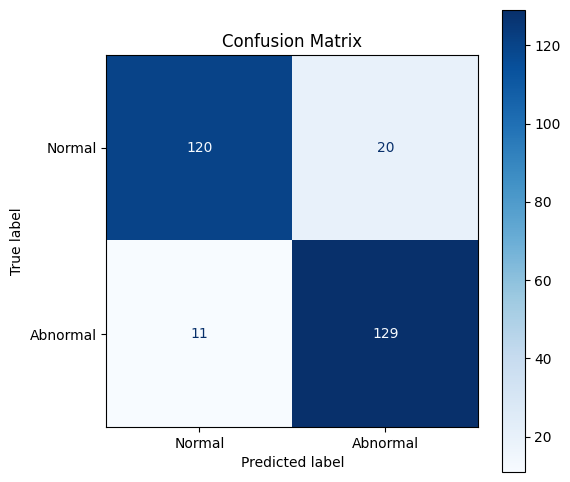


📁 Evaluation results saved to: /content/drive/MyDrive/Colab Notebooks/New_Project-UCF/models/LSTM-VideoLevel_both_20250526-183832


In [ ]:
import torch
import json
import os
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import numpy as np
from sklearn.metrics import ConfusionMatrixDisplay
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

SAVE_DIR = f'/content/drive/MyDrive/Colab Notebooks/New_Project-UCF/models/LSTM-VideoLevel_both_20250526-183832'


# Load the best model
checkpoint = torch.load(os.path.join(SAVE_DIR, 'best_model.pth'))
model = LSTMAnomalyDetector(input_dim=input_dim).to(device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

# Function to evaluate the model
def evaluate(model, loader):
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for features, labels, _ in loader:
            features, labels = features.to(device), labels.to(device)
            outputs = model(features)
            preds = (outputs > 0.5).float()  # Convert probabilities to binary predictions
            all_preds.append(preds.cpu().numpy())
            all_labels.append(labels.cpu().numpy())

    # Flatten the list of predictions and labels
    all_preds = np.concatenate(all_preds, axis=0)
    all_labels = np.concatenate(all_labels, axis=0)

    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)

    # Calculate confusion matrix
    conf_matrix = confusion_matrix(all_labels, all_preds)
    return accuracy, precision, recall, f1, conf_matrix

# Create DataLoader for evaluation
test_split = '/content/drive/MyDrive/Colab Notebooks/New_Project-UCF/UCF-Crime/splits/test_1.txt'
test_dataset = UCFDataset(test_split, gt_dict, frames_dict, features_dir, feature_type=FEATURE_TYPE)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# Evaluate the model
accuracy, precision, recall, f1, conf_matrix = evaluate(model, test_loader)

# Print results
print(f"\n📊 Evaluation Results:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

# Plot confusion matrix
fig, ax = plt.subplots(figsize=(6, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['Normal', 'Abnormal'])
disp.plot(cmap='Blues', ax=ax)
plt.title("Confusion Matrix")
plt.show()

# Optionally, save the evaluation results
eval_results = {
    'accuracy': accuracy,
    'precision': precision,
    'recall': recall,
    'f1_score': f1,
    'confusion_matrix': conf_matrix.tolist()  # Convert to list for JSON serialization
}

with open(os.path.join(SAVE_DIR, 'eval_results.json'), 'w') as f:
    json.dump(eval_results, f)

print(f"\n📁 Evaluation results saved to: {SAVE_DIR}")
